# Text Classfication using TinyBert
* Dataset: <https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn

import transformers
import torchflare.callbacks as cbs
import torchflare.metrics as metrics
import torchflare.criterion as crit
from torchflare.experiments import Experiment
from torchflare.datasets import TextDataloader


In [2]:
df = pd.read_csv("Train.csv")

In [3]:
train_df , valid_df =train_test_split(df , stratify = df.label,  test_size = 0.1, random_state = 42)

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

train_dl = TextDataloader.from_df(
                        df = train_df,
                        input_col = 'text',
                        label_cols = 'label',
                        tokenizer = tokenizer,
                        max_len = 128).get_loader(batch_size = 16 , shuffle = True)

valid_dl = TextDataloader.from_df(
                        df = valid_df,
                        input_col = 'text',
                        label_cols = 'label',
                        tokenizer = tokenizer,
                        max_len = 128).get_loader(batch_size = 16)

In [5]:
class Model(torch.nn.Module):

    def __init__(self):

        super(Model , self).__init__()
        self.bert = transformers.BertModel.from_pretrained(
            "prajjwal1/bert-tiny", return_dict=False
        )
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _ , o_2 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        return output

model = Model()

In [6]:
metric_list = [metrics.Accuracy(num_classes=2, multilabel=False)]

callbacks = [
    cbs.EarlyStopping(monitor="accuracy", patience=2, mode = "max"),
    cbs.ModelCheckpoint(monitor="accuracy" , mode = "max"),
    cbs.ReduceLROnPlateau(mode = "max" , patience = 2)
]

# I want to define some custom weight decay to model paramters.
# We will use model_params as an argument in optimizer_params to tell torchflare that, hey we are using custom optimizer params for model.
# If model_params arguments is not used, torchflare by default will use model.parameters() as default params to optimizer.
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias"]
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]


In [7]:
exp = Experiment(
    num_epochs=5,
    save_dir="./models",
    model_name="bert_cls.bin",
    fp16=True,
    device="cuda",
    compute_train_metrics=True,
    seed=42,
)

# Compiling the experiment
exp.compile_experiment(
    model=model,
    optimizer="AdamW",
    optimizer_params=dict(model_params = optimizer_parameters, lr=3e-5), # used model_params argument for custom optimizer params.
    callbacks=callbacks,
    criterion= crit.BCEWithLogitsFlat, # Using BCEWithLogitsFlat since I dont want to handle shapes my outputs and targets.
    metrics=metric_list,
    main_metric="accuracy",
)

# Training the models.
exp.run_experiment(train_dl = train_dl , valid_dl = valid_dl)


Epoch: 1/5
Train: 2250/2250 [=========================]- 94s 42ms/step - train_loss: 0.5171 - train_accuracy: 0.7350
Valid: 250/250 [=========================]- 6s 25ms/step - val_loss: 0.4294 - val_accuracy: 0.7413

Epoch: 2/5
Train: 2250/2250 [=========================]- 101s 45ms/step - train_loss: 0.3965 - train_accuracy: 0.7796
Valid: 250/250 [=========================]- 7s 28ms/step - val_loss: 0.3824 - val_accuracy: 0.7821

Epoch: 3/5
Train: 2250/2250 [=========================]- 107s 48ms/step - train_loss: 0.3456 - train_accuracy: 0.8030
Valid: 250/250 [=========================]- 9s 35ms/step - val_loss: 0.3628 - val_accuracy: 0.8043

Epoch: 4/5
Train: 2250/2250 [=========================]- 114s 50ms/step - train_loss: 0.2969 - train_accuracy: 0.8208
Valid: 250/250 [=========================]- 8s 32ms/step - val_loss: 0.3630 - val_accuracy: 0.8214

Epoch: 5/5
Train: 2250/2250 [=========================]- 115s 51ms/step - train_loss: 0.2553 - train_accuracy: 0.8354
Valid: 250

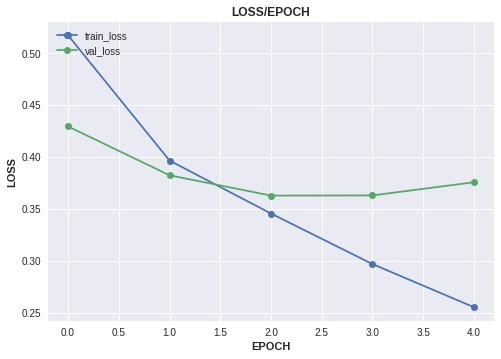

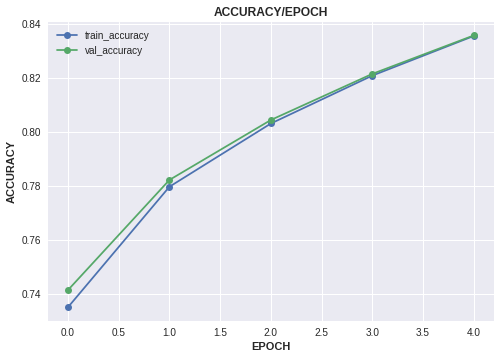

In [8]:
keys = ["loss" , "accuracy"]

exp.plot_history(keys = keys , save_fig = False , plot_fig = True)